# Create Forecasting Pipeline for LightGBM

In [1]:
# general import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional import
import geohash
import geopandas as gpd

# local import
from rdforecast import datasets

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
import lightgbm as lgb

def get_history(df, periods):
    """
    Append historical demands of TAZs as a new feature
    from `periods` of timesteps (15-min) before.
    """
    # create diff_zone indicator (curr TAZ != prev TAZ (up to periods) row-wise)
    shft = pd.DataFrame.shift(df[['geohash6', 'demand']], periods=periods)
    diff_zone = df['geohash6'] != shft['geohash6']
    shft.loc[diff_zone, 'demand'] = -1  # set -1 if different TAZ
    df['demand_t-%s'%periods] = shft['demand']
    df['demand_t-%s'%periods].fillna(-1, inplace=True)  # set NaNs to -1
    return df

def generate_features(df, history):
    """"""
    print('Retrieving historical demands...')
    [get_history(df, h) for h in history]
    print('Generating features...')
    # NOTE: be aware of timezones (see explore_function segmentation.ipynb)
    df['am_peak'] = ((df['hour'] >= 22) | (df['hour'] <= 2)).astype(int)
    df['midnight'] = ((df['hour'] >= 17) & (df['hour'] < 22)).astype(int)
    df['weekend'] = (df['dow'] > 4).astype(int)
    df['st_trend'] = df['demand_t-1'] - df['demand_t-2']
    df['mt_trend'] = df['demand_t-1'] - df['demand_t-5']
    df['hist_trend_1d'] = df['demand_t-96'] - df['demand_t-101']
    df['hist_trend_7d'] = df['demand_t-672'] - df['demand_t-677']
    print('Done.')
    return df

def eval_RMSE(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    assert len(y_true) == len(y_pred), 'Lengths mismatch.'
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(rmse)
    
def eval_MAPE(y_true, y_pred):
    assert len(y_true) == len(y_pred), 'Lengths mismatch.'
    mask = (y_true != 0)
    mape = (np.abs(y_true - y_pred) / y_true)[mask].mean()
    print(mape)
    return mape
    
def cap(old):
    """Caps predicted values to [0, 1]"""
    new = [min(1, y) for y in old]
    new = [max(0, y) for y in new]
    return np.array(new)

In [3]:
path = './input/'
train = pd.read_csv(path + 'train.csv')
train = datasets.process_timestamp(train)
train.head()

,geohash6,day,timestamp,demand,timestep,weekly,quarter,hour,dow
0,qp03wc,18,20:0,0.020072,1712,368,80,20,4
1,qp03pn,10,14:30,0.024721,922,250,58,14,3
2,qp09sw,9,6:15,0.102821,793,121,25,6,2
3,qp0991,32,5:0,0.088755,2996,308,20,5,4
4,qp090q,15,4:0,0.074468,1360,16,16,4,1


In [4]:
zone_labels = pd.read_csv(path+'zone_labels.csv')
train = train.merge(zone_labels, how='left', on='geohash6')

In [8]:
print('Decoding geohash...')
train['lon'], train['lat'] = zip(*[(latlon[1], latlon[0]) for latlon
                                   in train['geohash6'].map(geohash.decode)])

Decoding geohash...


In [9]:
train_full = datasets.expand_timestep(train, test_data=False)

Expanding training data and fill NaNs with 0 demands for all timesteps per TAZ...
Might take a couple of minutes... :)
Done.
Missing values:
geohash6            0
timestep            0
label_weekly_raw    0
label_weekly        0
label_daily         0
label_quarterly     0
active_rate         0
lon                 0
lat                 0
day                 0
weekly              0
quarter             0
hour                0
dow                 0
demand              0
dtype: int64


In [12]:
history = [1, 2, 5,
           96, 96*7, 96*14,
           96+1, 96*7+1, 96*14+1,
           96+5, 96*7+5, 96*14+5]
train_full = generate_features(train_full, history)

Retrieving historical demands...
Generating features...
Done.


In [13]:
train_full.columns

Index(['geohash6', 'timestep', 'label_weekly_raw', 'label_weekly',
       'label_daily', 'label_quarterly', 'active_rate', 'lon', 'lat', 'day',
       'weekly', 'quarter', 'hour', 'dow', 'demand', 'demand_t-1',
       'demand_t-2', 'demand_t-5', 'demand_t-96', 'demand_t-672',
       'demand_t-1344', 'demand_t-97', 'demand_t-673', 'demand_t-1345',
       'demand_t-101', 'demand_t-677', 'demand_t-1349', 'am_peak', 'midnight',
       'weekend', 'st_trend', 'mt_trend', 'hist_trend_1d', 'hist_trend_7d'],
      dtype='object')

In [21]:
features = ['timestep', 'label_weekly_raw', 'label_weekly',
            'label_daily', 'label_quarterly', 'active_rate', 'lon', 'lat', 'day',
            'weekly', 'quarter', 'hour', 'dow', 'demand_t-1',
            'demand_t-2', 'demand_t-5', 'demand_t-96', 'demand_t-672',
            'demand_t-1344', 'demand_t-97', 'demand_t-673', 'demand_t-1345',
            'demand_t-101', 'demand_t-677', 'demand_t-1349', 'am_peak', 'midnight',
            'weekend', 'st_trend', 'mt_trend', 'hist_trend_1d', 'hist_trend_7d']
# features = ['day', 'hour', 'demand_t-1', 'demand_t-5', 'demand_t-96', 'demand_t-672', 'weekly', 'lon', 'lat', 'label_km10', 'count', 'timestep']
features.extend(['demand'])
X = train_full[features]
print(X.dtypes.value_counts())
X.head()

float64    25
int64       8
dtype: int64


,timestep,label_weekly_raw,label_weekly,label_daily,label_quarterly,active_rate,lon,lat,day,weekly,...,demand_t-677,demand_t-1349,am_peak,midnight,weekend,st_trend,mt_trend,hist_trend_1d,hist_trend_7d,demand
0,0,1,3,2,2,0.992999,90.653687,-5.353088,1.0,0.0,...,-1.0,-1.0,1,0,0,0.000000,0.000000,0.0,0.0,0.054858
1,1,1,3,2,2,0.992999,90.653687,-5.353088,1.0,1.0,...,-1.0,-1.0,1,0,0,1.054858,1.054858,0.0,0.0,0.086209
2,2,1,3,2,2,0.992999,90.653687,-5.353088,1.0,2.0,...,-1.0,-1.0,1,0,0,0.031351,1.086209,0.0,0.0,0.050739
3,3,1,3,2,2,0.992999,90.653687,-5.353088,1.0,3.0,...,-1.0,-1.0,1,0,0,-0.035470,1.050739,0.0,0.0,0.075174
4,4,1,3,2,2,0.992999,90.653687,-5.353088,1.0,4.0,...,-1.0,-1.0,1,0,0,0.024435,1.075174,0.0,0.0,0.062867


In [561]:
# i = 3
# X = X[X['label_km10'] == i] # 4, 6

In [22]:
X_train = X[X['day'] <= 47]
# X_test = X[X['day'] > 47]

X_val = X_train[X_train['day'] > 40]
X_train = X_train[X_train['day'] <= 40]

y_train = X_train.pop('demand')
y_val = X_val.pop('demand')
# y_test = X_test.pop('demand')

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

# print(X_test.shape)
# print(y_test.shape)

(5084160, 32)
(5084160,)
(889728, 32)
(889728,)


In [23]:
X_train.loc[X_train.sample(frac=0.4).index, ['demand_t-1', 'st_trend']] = -1
X_val.loc[X_val.sample(frac=0.4).index, ['demand_t-1', 'st_trend']] = -1

# X_train.loc[X_train.sample(frac=0.4).index, ['demand_t-1']] = -1
# X_train.loc[X_train.sample(frac=0.1).index, 'demand_t-5'] = -1

In [24]:
params = {
    'num_leaves': 2**4,
    'objective': 'regression',
    'max_depth': 10,
    'min_data_in_leaf': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'rmse',
    'num_threads': 8
}

MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = ['hour']

print("=" * 50)
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cate_vars)
dval = lgb.Dataset(X_val, label=y_val, categorical_feature=cate_vars, reference=dtrain)
bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS,
                valid_sets=[dtrain, dval], early_stopping_rounds=100, verbose_eval=50
)
print("\n".join(("%s: %.2f" % x) for x in sorted(
    zip(X_train.columns, bst.feature_importance("gain")),
    key=lambda x: x[1], reverse=True
)))

/Users/Yuwen/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.


KeyboardInterrupt: 

In [642]:
# train (after capping)
y_pred = cap(bst.predict(X_train))
print('Train RMSE after capping:')
eval_RMSE(y_train, y_pred)
# validate (after capping)
y_pred = cap(bst.predict(X_val))
eval_RMSE(y_val, y_pred)
# test
y_pred = bst.predict(X_test)
eval_RMSE(y_test, y_pred)
y_pred = cap(y_pred)
eval_RMSE(y_test, y_pred)

0.027410625191749048
0.026197614174939068
0.025431226692788612
3.1975579396985117


In [654]:
# X_test.loc[X_test['day'] > 55, ['demand_t-1', 'st_trend']] = -1
X_test.loc[X_test['day'] > 55, 'demand_t-1'] = -1

# test
y_pred = bst.predict(X_test)
y_pred = cap(y_pred)
eval_RMSE(y_test, y_pred)
eval_MAPE(y_test, y_pred)

/home/yuwen/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.03258137386476364
4.583045298235022


In [664]:
y_test_ = y_test.loc[X_test_.index]
X_test_ = X_test[(X_test['timestep'] >= 5000) & (X_test['timestep'] < 5005)]
# test
y_pred_ = bst.predict(X_test_)
y_pred_ = cap(y_pred_)
eval_RMSE(y_test_, y_pred_)
eval_MAPE(y_test_, y_pred_)

0.027854293050372996
1.5601950246653082


In [657]:
result = pd.concat([X_test.reset_index(drop=True), pd.Series(y_test.values), pd.Series(y_pred)], axis=1, ignore_index=True)
result.columns = list(X_test.columns) + ['y_test', 'y_pred']
result['geohash6'] = [geohash.encode(lat, lon, 6) for lon, lat in zip(result['lon'], result['lat'])]
print(result.shape)
result.head()

(1786176, 15)


,day,hour,demand_t-1,demand_t-5,demand_t-96,demand_t-672,weekly,lon,lat,label_km10,count,timestep,y_test,y_pred,geohash6
0,48.0,0.0,0.0,0.0,0.0,0.0,480.0,90.653687,-5.484924,0,577,4512,0.000000,0.0,qp02yc
1,48.0,0.0,0.0,0.0,0.0,0.0,481.0,90.653687,-5.484924,0,577,4513,0.000000,0.0,qp02yc
2,48.0,0.0,0.0,0.0,0.0,0.0,482.0,90.653687,-5.484924,0,577,4514,0.000000,0.0,qp02yc
3,48.0,0.0,0.0,0.0,0.0,0.0,483.0,90.653687,-5.484924,0,577,4515,0.000000,0.0,qp02yc
4,48.0,1.0,0.0,0.0,0.0,0.0,484.0,90.653687,-5.484924,0,577,4516,0.005397,0.0,qp02yc


In [658]:
tmp = list(result['geohash6'][1:].values == result['geohash6'][:-1].values)
tmp.extend([False])
result['same_zone'] = tmp

result.sort_values(['geohash6', 'timestep'], inplace=True)
tmp = list(result['y_pred'][1:])
tmp.extend([np.nan])
result['y_pred_shift'] = tmp

y_test_ = result[result['same_zone']]['y_test']
y_pred_ = result[result['same_zone']]['y_pred_shift']

# y_test_ = result[result['same_zone']].dropna(subset=['y_pred_shift'])['y_test']
# y_pred_ = result[result['same_zone']].dropna(subset=['y_pred_shift'])['y_pred_shift']

In [659]:
eval_RMSE(y_test_, y_pred_)
eval_MAPE(y_test_, y_pred_)

0.029914262596373833
4.352338436546647


In [615]:
eval_RMSE(y_test_, y_pred_)
eval_MAPE(y_test_, y_pred_)

0.016124419698812436
3.1787380207846567


In [528]:
# AAAI 2018 improvement from HA
print((12.167 - 9.642) / 12.167)
# this improvement from HA
print((0.03654 - 0.02661) / 0.03654)

0.2075285608613463
0.2717569786535304


In [339]:
dow_hist_avg = data[['geohash6', 'dow', 'demand']].groupby(['geohash6', 'dow']).mean().reset_index()
dow_hist_avg.columns = ['geohash6', 'dow', 'hist_avg_dow']
result = result.merge(dow_hist_avg, how='left', on=['geohash6', 'dow'])
result['hist_avg_dow'].fillna(0, inplace=True)

In [319]:
weekly_hist_avg = weekly.iloc[:, :672].stack().reset_index()
weekly_hist_avg.columns = ['geohash6', 'weekly', 'hist_avg_weekly']
result = result.merge(weekly_hist_avg, how='left', on=['geohash6', 'weekly'])

In [349]:
# baselines
eval_RMSE(y_test, X_test['demand_t-1'])
eval_RMSE(y_test, (X_test['demand_t-1'] + X_test['hist_trend_7d']))
eval_RMSE(y_test, X_test['demand_t-96'])
eval_RMSE(y_test, X_test['demand_t-672'])
eval_RMSE(y_test, result['hist_avg'])
eval_RMSE(y_test, result['hist_avg_dow'])

0.7028205023050756
0.7033028725884548
0.05208630121105032
0.05569556937420075
0.036548939652720706
0.07848614393726931


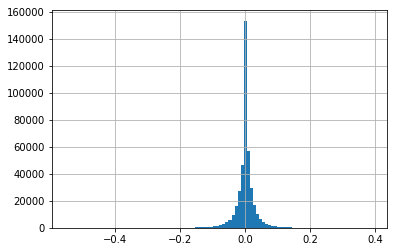

In [647]:
result['diff'] = (y_pred - y_test)
result['diff'].hist(bins=100)

In [43]:
bad = result[np.abs(result['diff']) >= result['diff'].std() * 3]
good = result[np.abs(result['diff']) <= 0.001]

In [40]:
bad['geohash6'].value_counts()[:10]

qp06pm    253
qp03r0    247
qp03pc    224
qp06nv    214
qp03qg    214
qp03r9    207
qp08b7    173
qp03ny    171
qp03pt    155
qp09h7    149
Name: geohash6, dtype: int64

In [44]:
good['geohash6'].value_counts()[:10]

qp0d0g    1260
qp02z9    1222
qp0d4v    1132
qp09fq    1124
qp0d4c    1068
qp08cp     995
qp09dr     964
qp02zm     907
qp09fh     860
qp09f3     849
Name: geohash6, dtype: int64

In [61]:
bad['label_km10'].value_counts() / len(bad)

0    0.544569
5    0.178712
3    0.131954
8    0.096912
7    0.023434
4    0.016316
6    0.007446
9    0.000329
1    0.000329
Name: label_km10, dtype: float64

In [62]:
good['label_km10'].value_counts() / len(good)

0    0.484159
5    0.262548
8    0.128811
3    0.066417
9    0.022745
4    0.018828
6    0.011844
1    0.003094
7    0.000783
2    0.000770
Name: label_km10, dtype: float64

# >>> examination
# >>> use lat/lon, how to add more spatial features?
goods are not necessarily as good as you thought, bad are not as bad, why?
- zeros are easy to get
- some good ones are at very small scale

In [567]:
# result[result['label_km9_x'] == i].head()
result[result['label_km10'] == i]['geohash6'].unique()[:10]

array(['qp02zj', 'qp02zt', 'qp03mg', 'qp03ny', 'qp03nz', 'qp03p7',
       'qp03pp', 'qp03pr', 'qp03r0', 'qp03r1'], dtype=object)

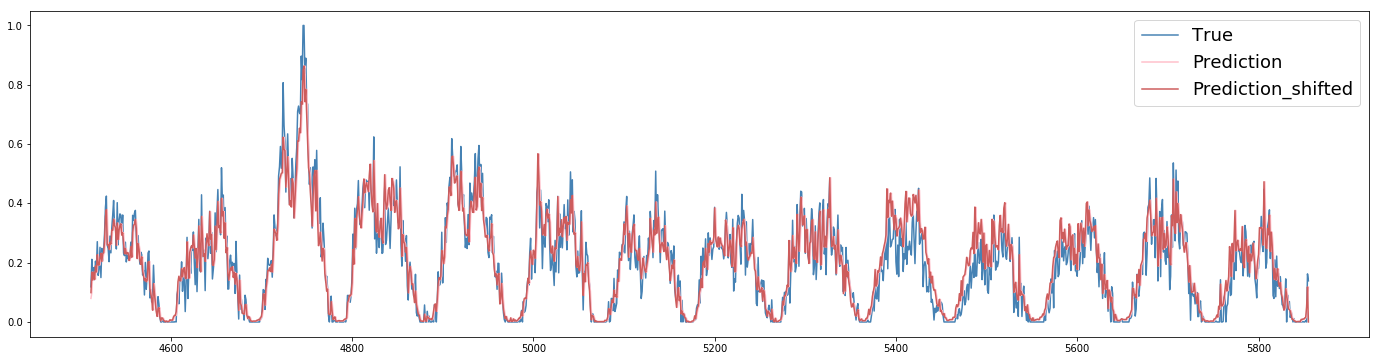

In [629]:
gh = 'qp02zt'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='pink', label='Prediction')
ax.plot(sample['timestep'], sample['y_pred_shift'], color='indianred', label='Prediction_shifted')
plt.legend(fontsize=18)

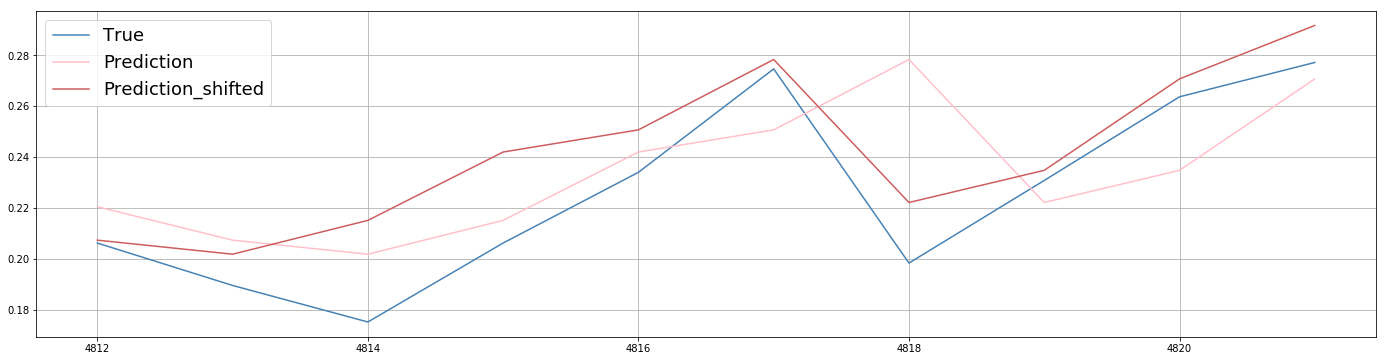

In [650]:
s = 300
e = 310
gh = 'qp03r0'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'][s:e], sample['y_test'][s:e], color='steelblue', label='True')
ax.plot(sample['timestep'][s:e], sample['y_pred'][s:e], color='pink', label='Prediction')
ax.plot(sample['timestep'][s:e], sample['y_pred_shift'][s:e], color='indianred', label='Prediction_shifted')
plt.legend(fontsize=18)
plt.grid()

# >>> surge prediction is often off
# >>> cap output at (0,1)
# remove outliers for training?
remove demand < 10 (actual) as suggested by AAAI 2018
# sanity check undone

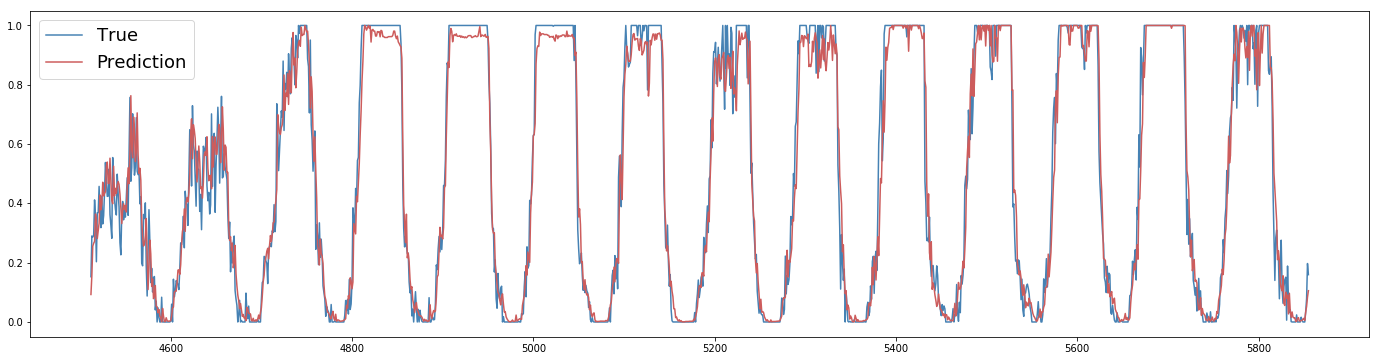

In [236]:
# t-1, t-5, t-1D, t-7D (new full_df) capping
gh = 'qp02zz'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

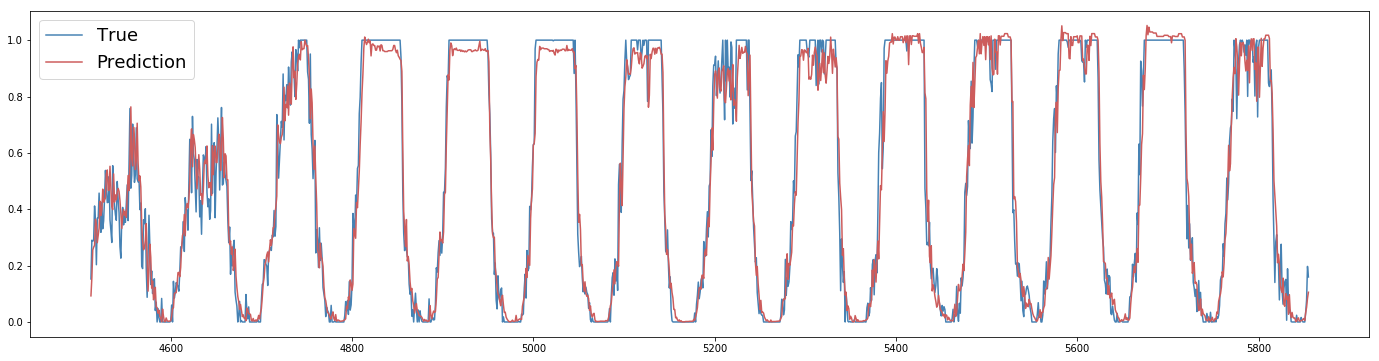

In [221]:
# t-1, t-5, t-1D, t-7D (new full_df)
gh = 'qp02zz'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

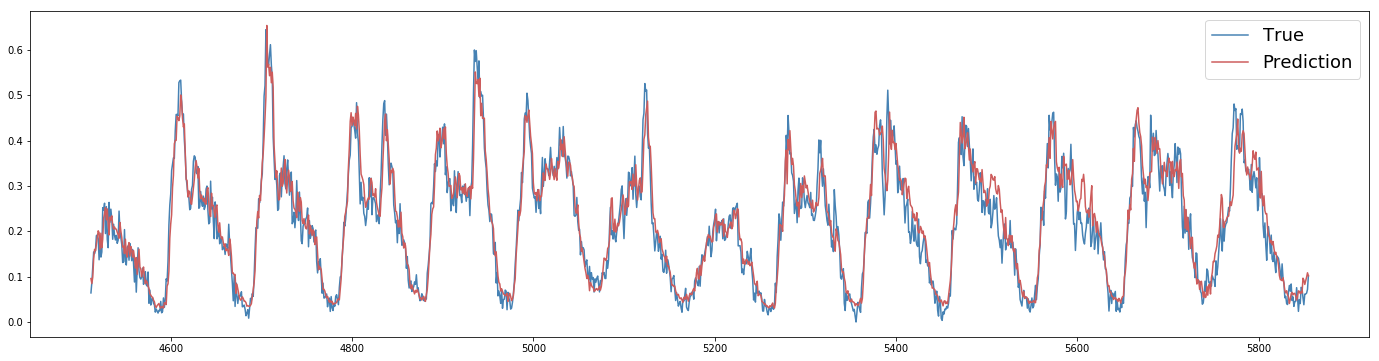

In [255]:
# new full_df all (i=4)
gh = 'qp03x5'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

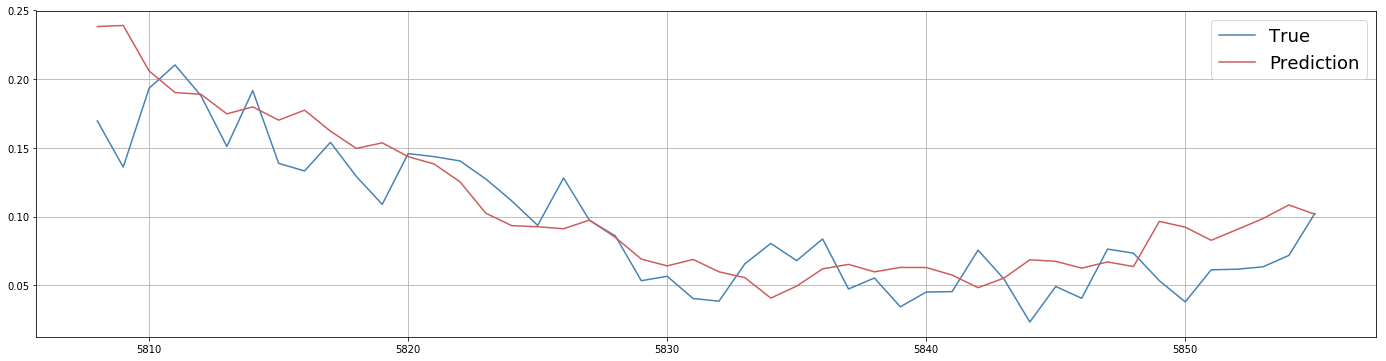

In [258]:
# new full_df all (i=4)
gh = 'qp03x5'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'][-48:], sample['y_test'][-48:], color='steelblue', label='True')
ax.plot(sample['timestep'][-48:], sample['y_pred'][-48:], color='indianred', label='Prediction')
plt.legend(fontsize=18)
plt.grid()

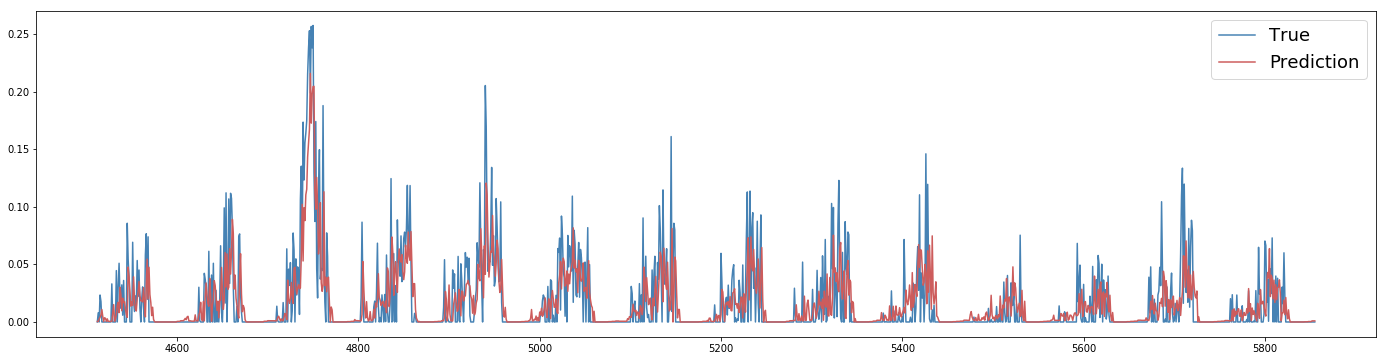

In [237]:
# t-1, t-5, t-1D, t-7D (new full_df)
gh = 'qp02z5'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

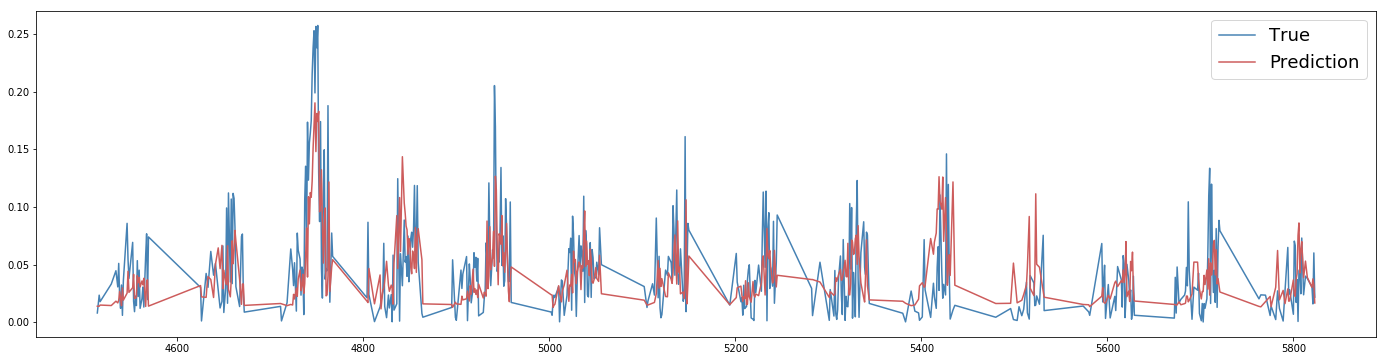

In [269]:
# t-1, t-5, t-1D, t-7D
gh = 'qp02z5'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

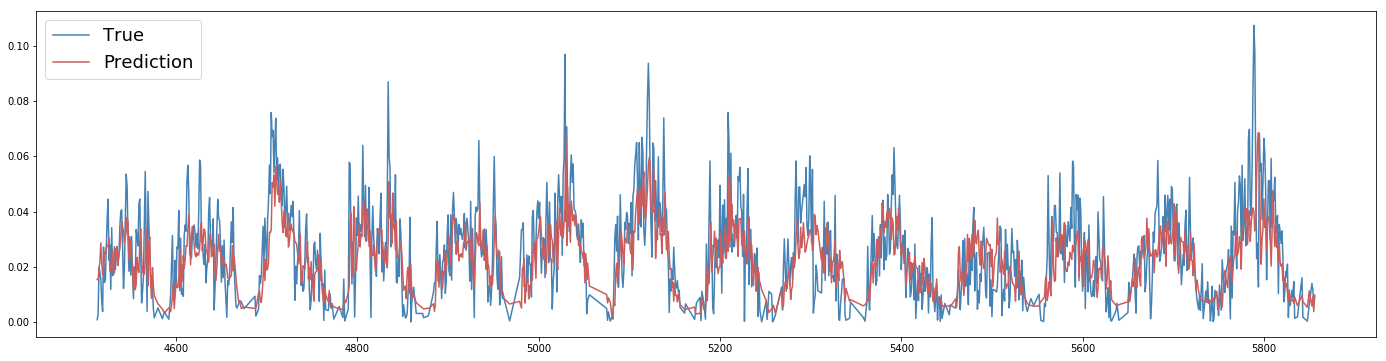

In [97]:
# t-1, t-5, t-1D, t-7D, weekend, st_trend (km_label_x == 0)
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

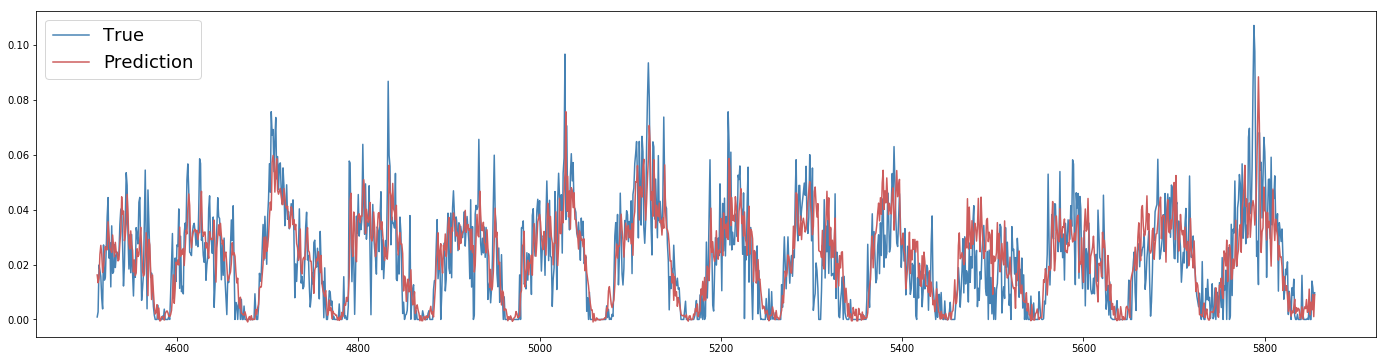

In [92]:
# t-1, t-5, t-1D, t-7D, weekend (new full_df)
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

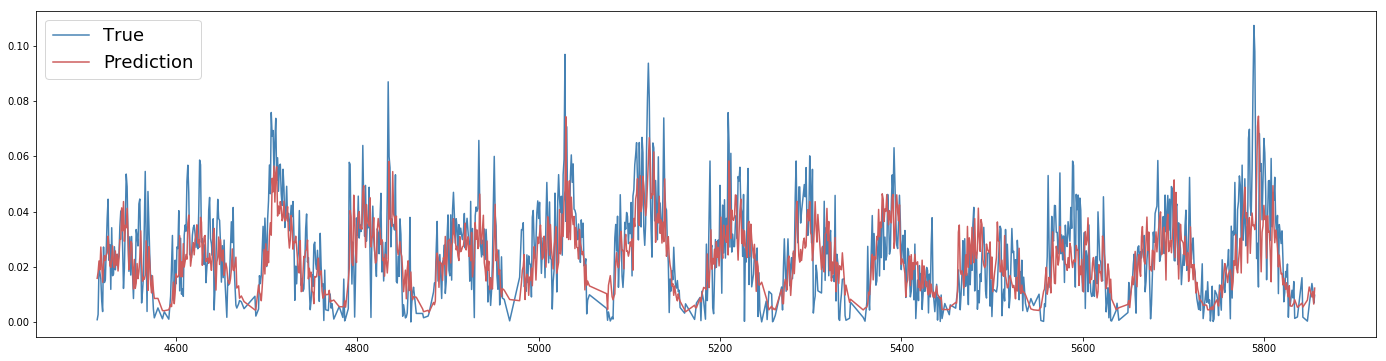

In [60]:
# t-1, t-5, t-1D, t-7D, weekend
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

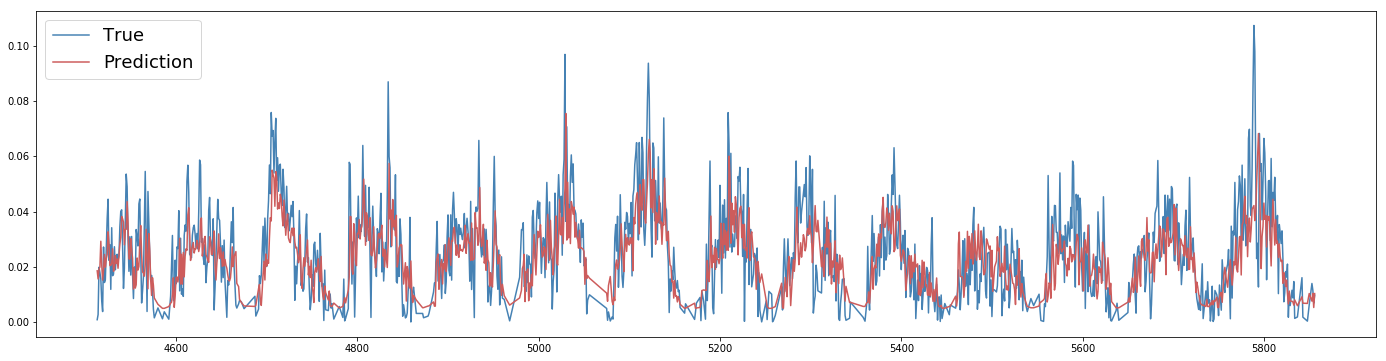

In [256]:
# t-1, t-5, t-1D, t-7D (km_label_x == 0)
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

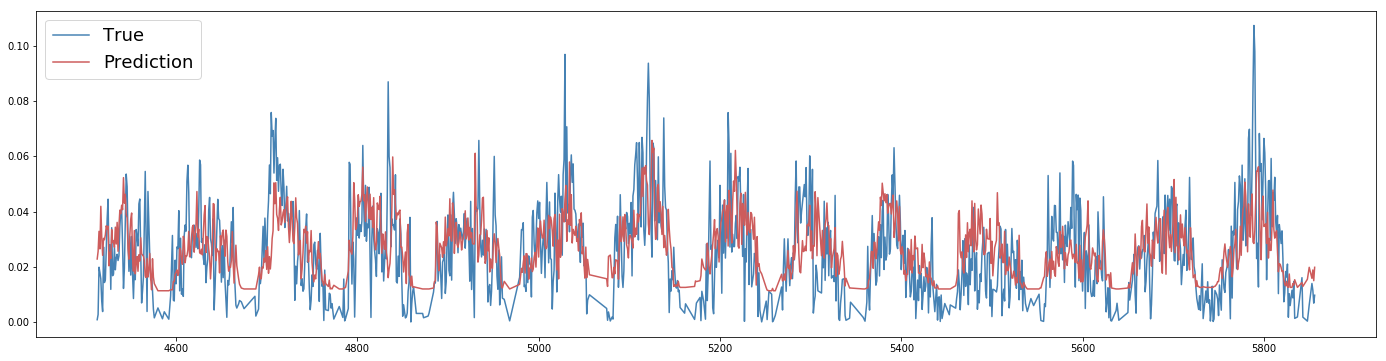

In [220]:
# t-5, t-1D, t-7D
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

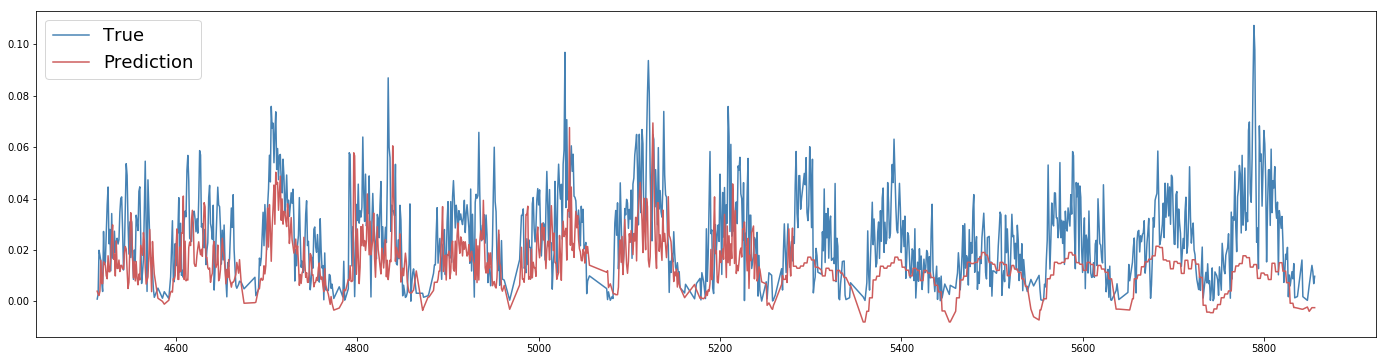

In [176]:
# clustering as cate
gh = 'qp03jr'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

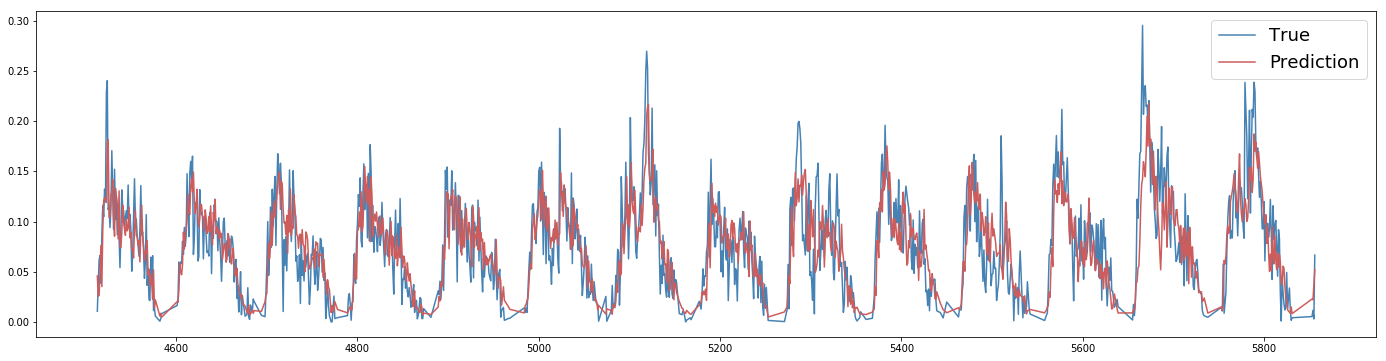

In [231]:
# t-1, t-5, t-1D, t-7D
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

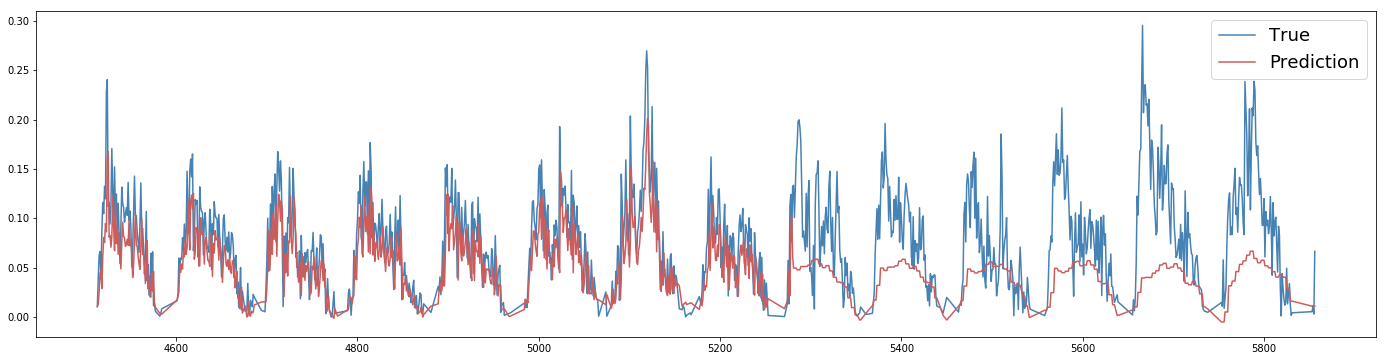

In [160]:
# clustering as cate
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

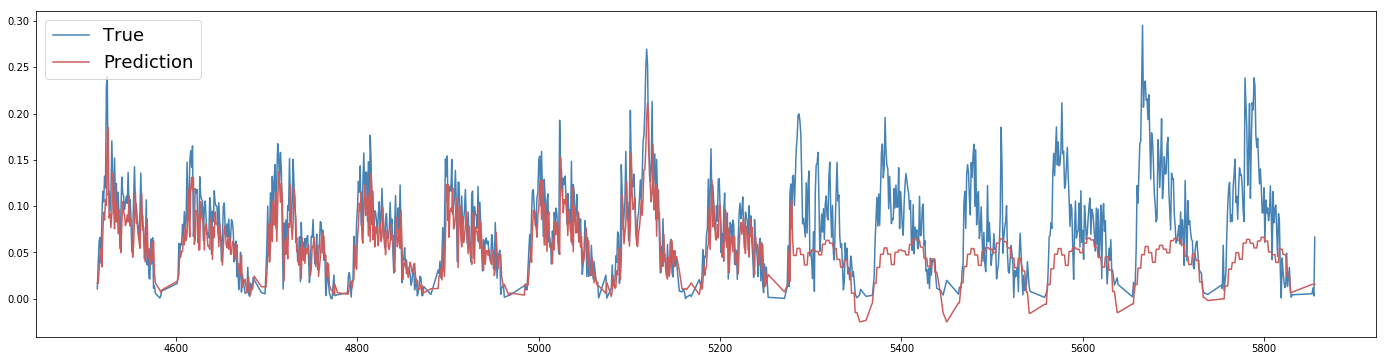

In [128]:
# dow as cate
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

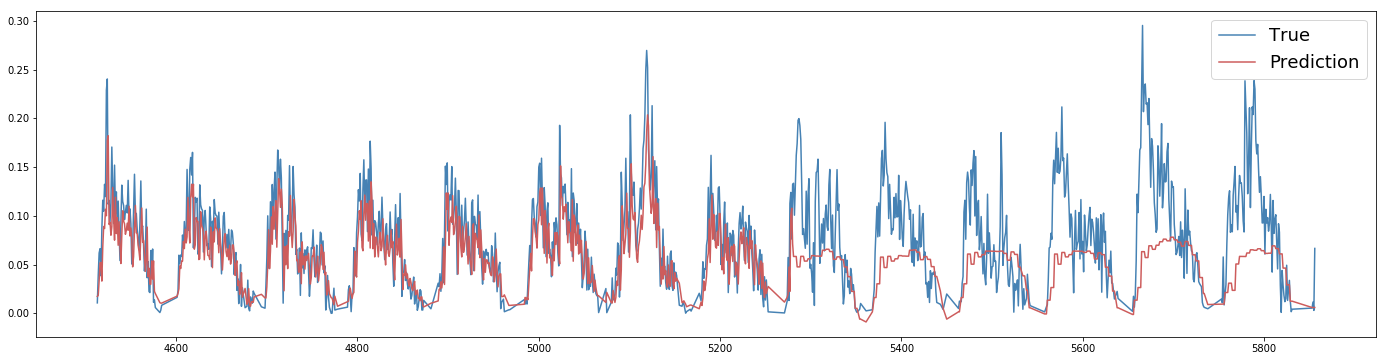

In [123]:
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

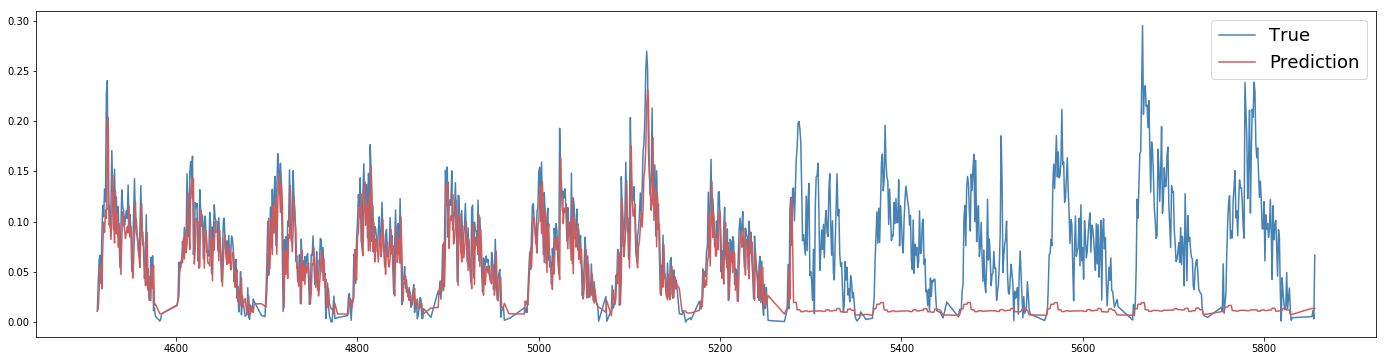

In [110]:
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

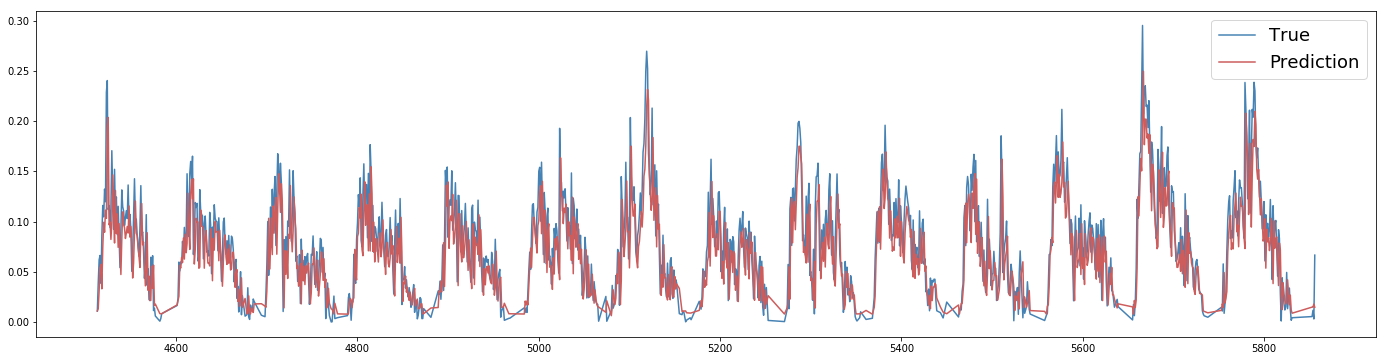

In [102]:
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

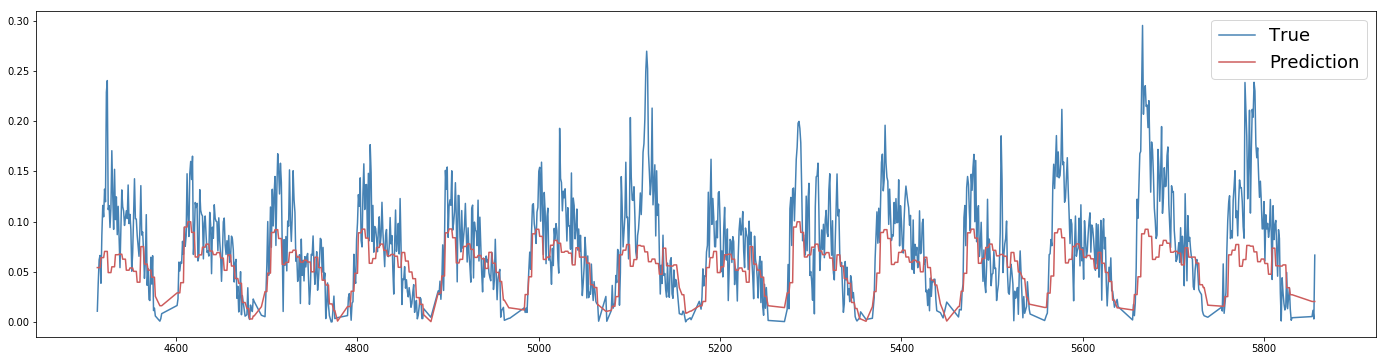

In [70]:
gh = 'qp093r'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

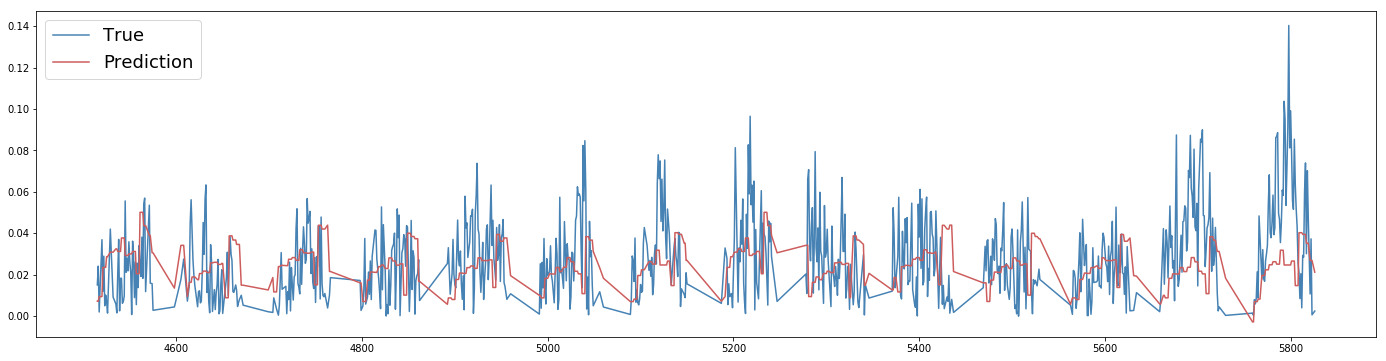

In [158]:
# xgboost
gh = 'qp091w'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

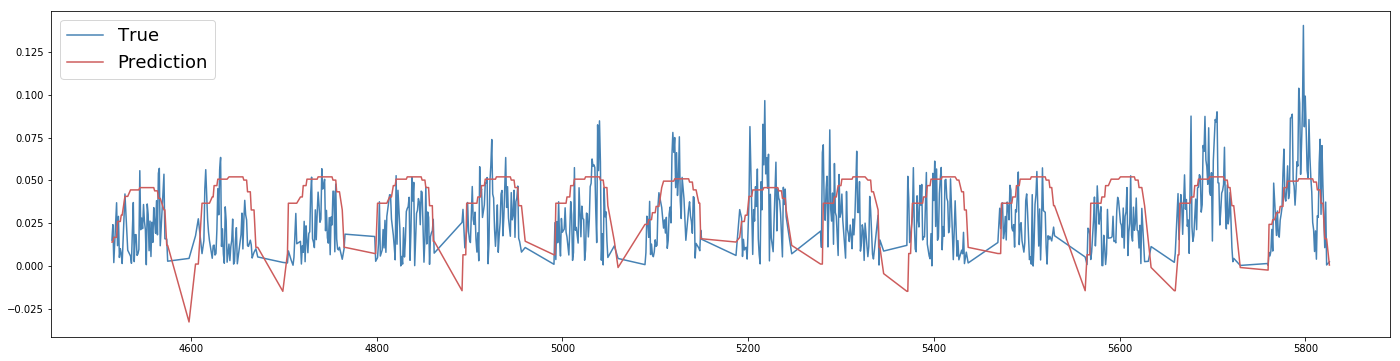

In [148]:
gh = 'qp091w'
sample = result[result['geohash6'] == gh].sort_values('timestep')

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
ax.plot(sample['timestep'], sample['y_test'], color='steelblue', label='True')
ax.plot(sample['timestep'], sample['y_pred'], color='indianred', label='Prediction')
plt.legend(fontsize=18)

In [ ]:
"""LGBM Starter

This is watered-down version of one of my earlier scripts. 
Only very basic features are retained so hopefully it won't ruin the fun for you.
"""
from datetime import date, timedelta

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

df_train = pd.read_csv(
    '../input/train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)

df_test = pd.read_csv(
    "../input/test.csv", usecols=[0, 1, 2, 3, 4],
    dtype={'onpromotion': bool},
    parse_dates=["date"]  # , date_parser=parser
).set_index(
    ['store_nbr', 'item_nbr', 'date']
)

items = pd.read_csv(
    "../input/items.csv",
).set_index("item_nbr")

df_2017 = df_train[df_train.date.isin(
    pd.date_range("2017-05-31", periods=7 * 11))].copy()
del df_train

promo_2017_train = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)
promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)
del promo_2017_test, promo_2017_train

df_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)

items = items.reindex(df_2017.index.get_level_values(1))

def get_timespan(df, dt, minus, periods):
    return df[
        pd.date_range(dt - timedelta(days=minus), periods=periods)
    ]

def prepare_dataset(t2017, is_train=True):
    X = pd.DataFrame({
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values
    })
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[
            t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_2017[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

print("Preparing dataset...")
t2017 = date(2017, 6, 21)
X_l, y_l = [], []
for i in range(4):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(
        t2017 + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset(date(2017, 7, 26))
X_test = prepare_dataset(date(2017, 8, 16), is_train=False)

print("Training and predicting models...")
params = {
    'num_leaves': 2**5 - 1,
    'objective': 'regression_l2',
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}

MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = []
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([items["perishable"]] * 4) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items["perishable"] * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
    )
    print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))
    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).transpose()))

print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('lgb.csv', float_format='%.4f', index=None)


# XGBoost

In [154]:
model_spec = dict(max_depth=10,
                learning_rate=0.1,
                n_estimators=1000,
                silent=True, objective='reg:squarederror',
                booster='gbtree',
                n_jobs=-1,
                gamma=0,
                min_child_weight=1,
                max_delta_step=0,
                subsample=1,
                colsample_bytree=1,
                colsample_bylevel=1,
                reg_alpha=0,
                reg_lambda=1,
                scale_pos_weight=1,
                base_score=0.5,
                random_state=0,
                eval_metric='rmse')

In [155]:
import xgboost
best_xgb_model = xgboost.XGBRegressor(**model_spec)
best_xgb_model.fit(X_train, y_train, eval_metric='rmse')

/home/yuwen/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/yuwen/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='rmse', gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbosity=1)

In [156]:
# train
y_pred = best_xgb_model.predict(X_train)
eval_RMSE(y_train, y_pred)
# test
y_pred = best_xgb_model.predict(X_test)
eval_RMSE(y_test, y_pred)

0.03183241932201408
0.08018216420847601


In [152]:
# train
y_pred = best_xgb_model.predict(X_train)
eval_RMSE(y_train, y_pred)
# test
y_pred = best_xgb_model.predict(X_test)
eval_RMSE(y_test, y_pred)

0.12162863565666235
0.13138516460122748


In [157]:
result = pd.concat([X_test.reset_index(drop=True), pd.Series(y_test.values), pd.Series(y_pred)], axis=1, ignore_index=True)
result.columns = list(X_test.columns) + ['y_test', 'y_pred']
result['geohash6'] = [geohash.encode(lat, lon, 6) for lon, lat in zip(result['lon'], result['lat'])]
print(result.shape)
result.head()

(992829, 11)


,day,hour,timestep,dow,label_km9_x,label_km9_y,lon,lat,y_test,y_pred,geohash6
0,51,20,4884.0,2,7,4,90.631714,-5.408020,0.000293,0.004012,qp03nr
1,48,6,4538.0,6,4,7,90.763550,-5.364075,0.054170,0.073783,qp093r
2,52,11,4944.0,3,7,4,90.664673,-5.364075,0.359406,0.151729,qp03rp
3,48,11,4559.0,6,1,5,90.609741,-5.391541,0.057255,0.037799,qp03mf
4,56,10,5321.0,0,1,1,90.774536,-5.413513,0.008772,0.025520,qp091w
